In [1]:
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from src.classes import HitBox, TankProperties32x2
from src.dataprocessing import get_measured_potential
from src.vae_model import vae_model
from src.visualization import (
    plot_latent_space_with_tsne,
    plot_loss_history,
    plot_meas_coords,
    plot_meas_coords_wball,
    plot_mesh,
    plot_rball,
    plot_voxel,
)
from src.voxel_util import (
    gen_voxel_ball_data,
    gen_voxel_brick_data,
    random_voxel_ball,
    random_voxel_brick,
    read_json_file,
    scale_realworld_to_intdomain,
    voxel_ball,
)
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

2024-01-02 14:57:40.587432: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-02 14:57:40.587533: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-02 14:57:40.588331: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-02 14:57:40.673500: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# sources
# https://github.com/IsaacGuan/3D-VAE/blob/master/train.py
# https://github.com/ffriese/voxel_vae/tree/master
# https://github.com/ajbrock/Generative-and-Discriminative-Voxel-Modeling/blob/master/Generative/VAE.py

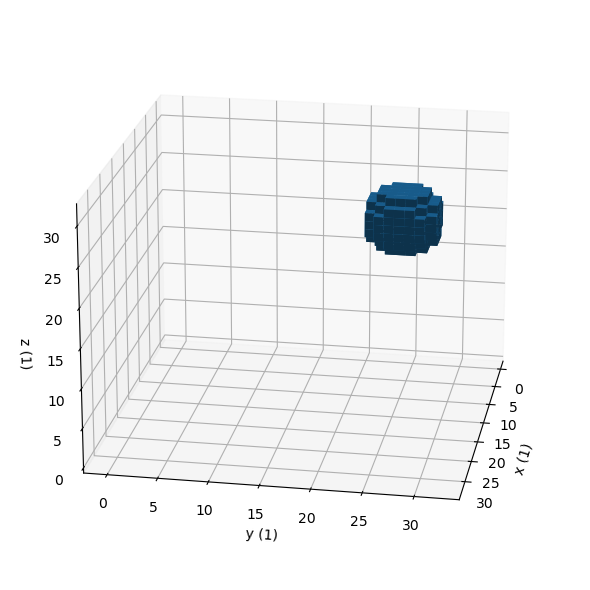

In [5]:
ball = True
if ball:
    d = 4
    plot_voxel(random_voxel_ball(d=d))
else:
    d_xyz = [5, 5, 5]
    plot_voxel(random_voxel_brick(d_xyz=d_xyz))

In [15]:
n_gammas = 400
if ball:
    gamma_train = gen_voxel_ball_data(num=n_gammas, d=d)
else:
    gamma_train = gen_voxel_brick_data(num=n_gammas, d_xyz=d_xyz)

print(gamma_train.shape)

(400, 32, 32, 32, 1)


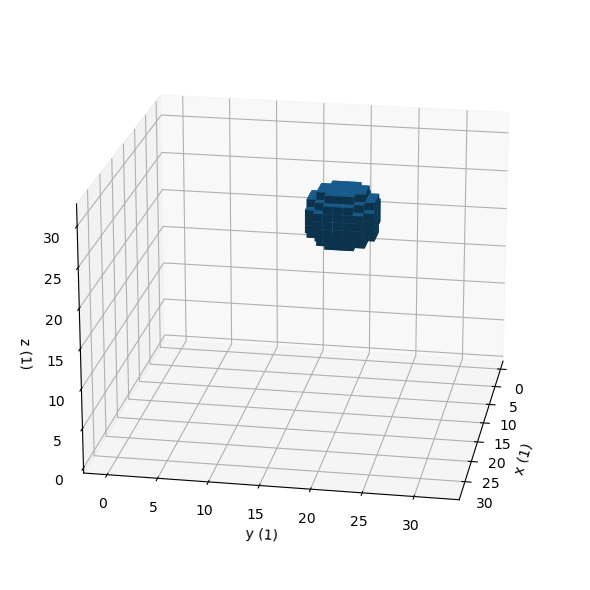

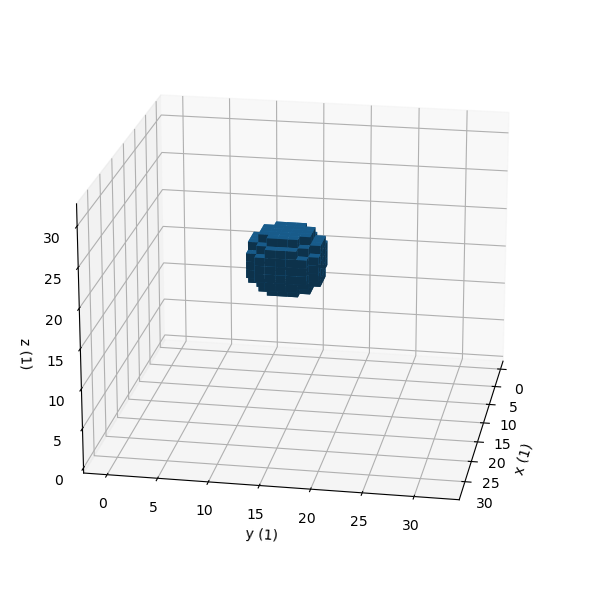

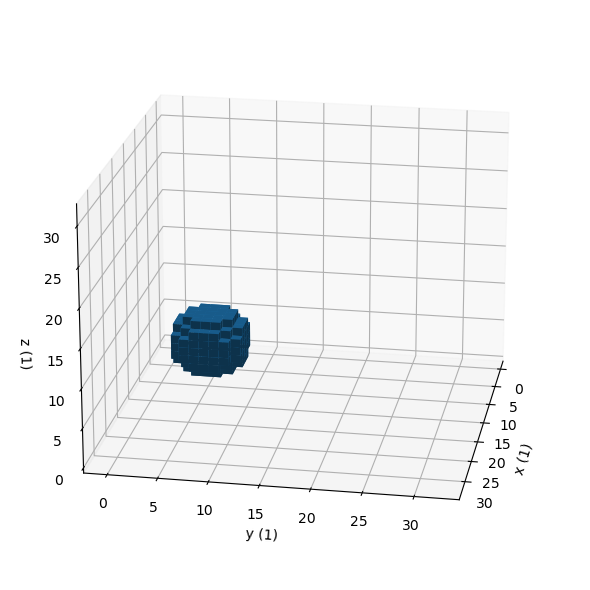

In [16]:
ns = 100
for idx in np.random.randint(0, ns, size=3):
    plot_voxel(gamma_train[idx, :, :, :, 0])

In [20]:
vae = vae_model(input_shape=(32, 32, 32, 1), beta=1.05)
vae.compile(optimizer=Adam())
epochs = 300
batch_size = 64

cb = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=0, start_from_epoch=250)

history = vae.fit(gamma_train, epochs=epochs, batch_size=batch_size, callbacks=[cb])

Epoch 1/300
7/7 [==============================] - 6s 19ms/step - loss: 2151.4284 - reconstruction_loss: 1924.9661 - kl_loss: 0.0390
Epoch 2/300
7/7 [==============================] - 0s 19ms/step - loss: 1772.0872 - reconstruction_loss: 1769.8442 - kl_loss: 0.0564
Epoch 3/300
7/7 [==============================] - 0s 16ms/step - loss: 1648.4735 - reconstruction_loss: 1623.9414 - kl_loss: 0.1008
Epoch 4/300
7/7 [==============================] - 0s 19ms/step - loss: 1571.5035 - reconstruction_loss: 1557.6458 - kl_loss: 0.4248
Epoch 5/300
7/7 [==============================] - 0s 16ms/step - loss: 1527.8546 - reconstruction_loss: 1527.7089 - kl_loss: 1.9215
Epoch 6/300
7/7 [==============================] - 0s 18ms/step - loss: 1515.7861 - reconstruction_loss: 1505.2328 - kl_loss: 4.7170
Epoch 7/300
7/7 [==============================] - 0s 18ms/step - loss: 1493.4546 - reconstruction_loss: 1484.4272 - kl_loss: 7.2390
Epoch 8/300
7/7 [==============================] - 0s 16ms/step - los

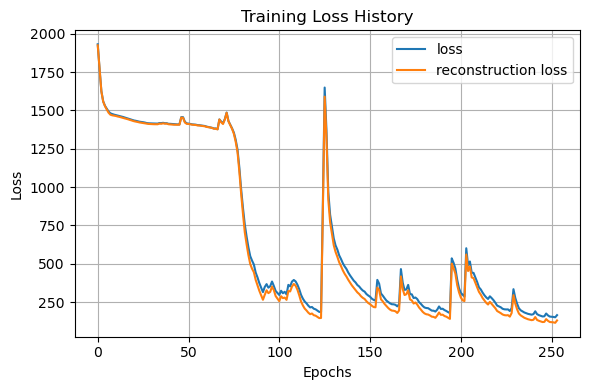

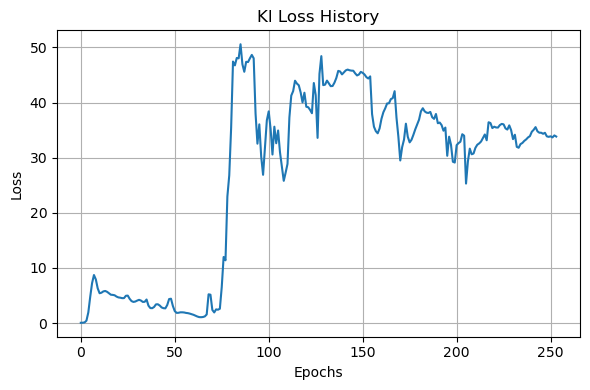

In [21]:
plot_loss_history(history)

plt.figure(figsize=(6, 4))
plt.title("Kl Loss History")
plt.plot(history.history["kl_loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.tight_layout()
plt.show()

In [22]:
if ball:
    gamma_test = gen_voxel_ball_data(num=100, d=d)
else:
    gamma_test = gen_voxel_brick_data(num=100, d_xyz=d_xyz)

4/4 [==============================] - 0s 23ms/step


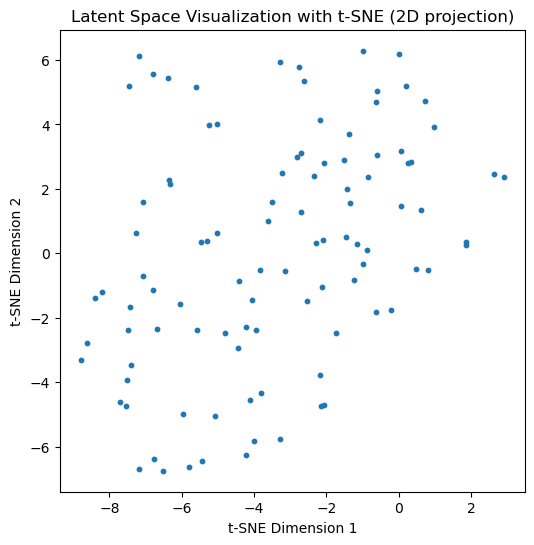

In [23]:
z_mean, z_log_var, z = vae.encoder.predict(gamma_test)
plot_latent_space_with_tsne(z_log_var)

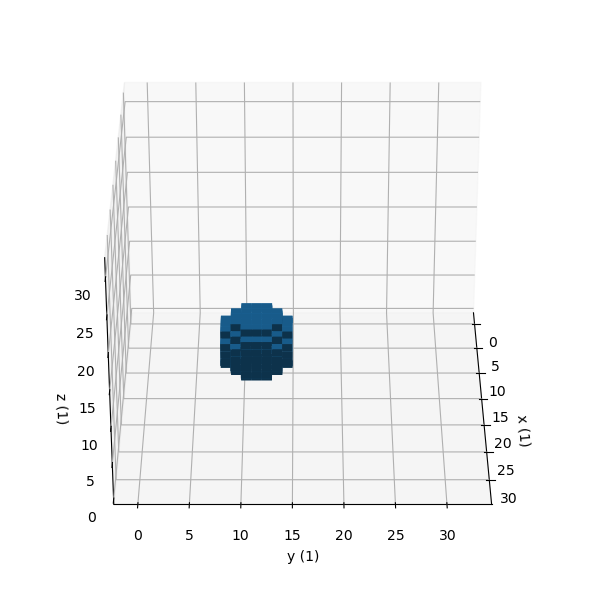

1/1 [==============================] - 0s 26ms/step


In [30]:
if ball:
    sgl_data = gen_voxel_ball_data(1, d=d)
else:
    sgl_data = gen_voxel_brick_data(1, d_xyz=d_xyz)
plot_voxel(sgl_data[0, :, :, :, 0], azim=0, elev=30)
z_mean, z_log_var, z = vae.encoder.predict(sgl_data)

1/1 [==============================] - 0s 24ms/step


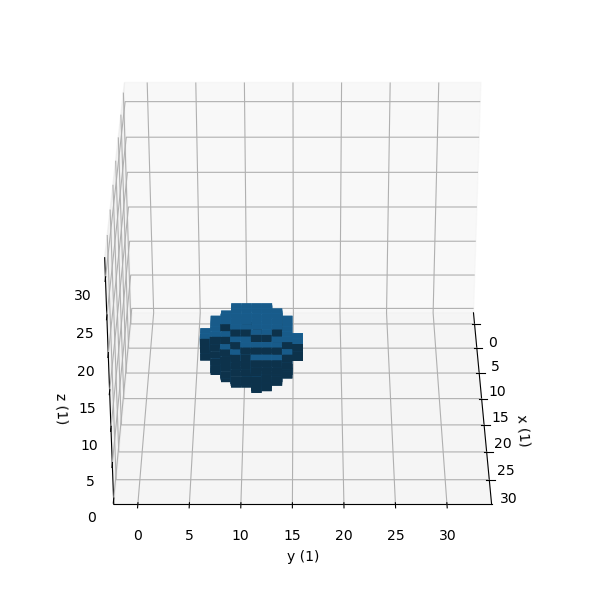

In [31]:
sgl_pred = vae.decoder.predict(z)
sgl_pred = np.squeeze(sgl_pred, axis=4)
sgl_pred = np.squeeze(sgl_pred, axis=0)
# sgl_pred = np.abs(np.round(sgl_pred))
sgl_pred = np.clip(sgl_pred, a_min=0, a_max=1)

plot_voxel(sgl_pred, azim=0, elev=30)

In [32]:
vae.save_weights("models/vae_weights_beta.h5")
vae.save("models/vae_beta.keras")

/home/jath/.conda/envs/TF2_12/lib/python3.11/site-packages/keras/src/saving/saving_api.py:164: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  saving_lib.save_model(model, filepath)


## Load VAE

## Build Mapper

In [77]:
l_path = "measurements/acryl_skip_8_d_30/"

json_data = read_json_file(l_path + "info.json")
hitbox = HitBox(**json_data["HitBox"])
tank = TankProperties32x2(**json_data["TankProperties32x2"])

In [78]:
empty_tank_before = list()
for path in np.sort(glob.glob(l_path + "empty_tank/b*")):
    print(path)
    tmp = np.load(path, allow_pickle=True)
    empty_tank_before.append(np.abs(get_measured_potential(tmp, shape_type="vector")))
empty_tank_before = np.array(empty_tank_before)

empty_tank_after = list()
for path in np.sort(glob.glob(l_path + "empty_tank/a*")):
    print(path)
    tmp = np.load(path, allow_pickle=True)
    empty_tank_after.append(np.abs(get_measured_potential(tmp, shape_type="vector")))
empty_tank_after = np.array(empty_tank_after)

measurements/acryl_skip_8_d_30/empty_tank/before_000000.npz
measurements/acryl_skip_8_d_30/empty_tank/before_000001.npz
measurements/acryl_skip_8_d_30/empty_tank/before_000002.npz
measurements/acryl_skip_8_d_30/empty_tank/before_000003.npz
measurements/acryl_skip_8_d_30/empty_tank/before_000004.npz
measurements/acryl_skip_8_d_30/empty_tank/after_000000.npz
measurements/acryl_skip_8_d_30/empty_tank/after_000001.npz
measurements/acryl_skip_8_d_30/empty_tank/after_000002.npz
measurements/acryl_skip_8_d_30/empty_tank/after_000003.npz
measurements/acryl_skip_8_d_30/empty_tank/after_000004.npz


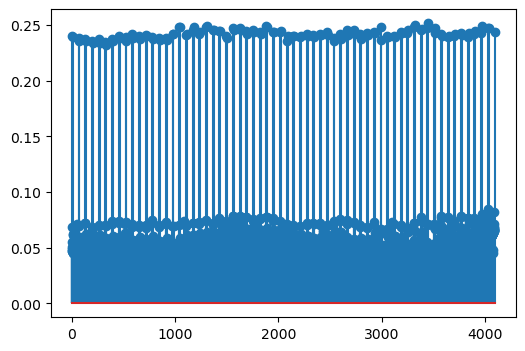

In [79]:
mean_bf = np.mean(empty_tank_before[1:], axis=0)
mean_af = np.mean(empty_tank_after[:], axis=0)
# mean ground value:
mean_ground = np.mean([mean_bf, mean_af], axis=0)
plt.figure(figsize=(6, 4))
plt.stem(mean_ground)
plt.show()

In [80]:
φ_n = list()
γ_n = list()

for path in tqdm(np.sort(glob.glob(l_path + "data/*"))):
    tmp = np.load(path, allow_pickle=True)
    φ_n.append(np.abs(get_measured_potential(tmp, shape_type="vector")) - mean_ground)
    ball = tmp["anomaly"].tolist()
    coordinate = [ball.y, ball.x, ball.z]
    d = 4
    x0, y0, z0 = scale_realworld_to_intdomain(coordinate, hitbox, d=d)
    γ_n.append(voxel_ball(y0, x0, z0, d=d))

γ_n = np.array(γ_n)
φ_n = np.array(φ_n)

_, _, z_n = vae.encoder.predict(np.expand_dims(γ_n, axis=4))

100%|██████████| 7450/7450 [01:16<00:00, 97.64it/s] 


<StemContainer object of 3 artists>

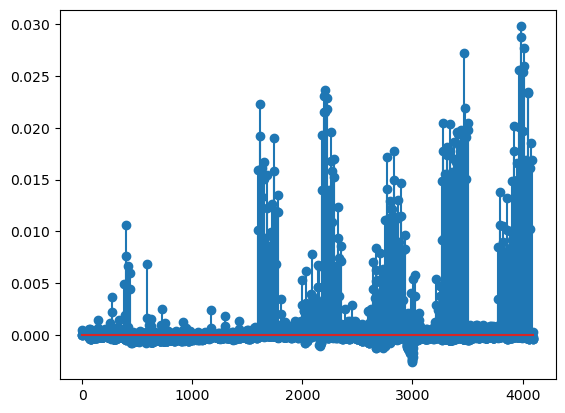

In [84]:
plt.stem(φ_n[100, :])

In [86]:
# train φ_n->z_n
# φ_n_train, φ_n_test, z_n_train, z_n_test, γ_n_train, γ_n_test = train_test_split(
#    φ_n,
#    z_n,
#    γ_n,
#    test_size=0.05,
#    random_state=42,
#    shuffle=False,
# )

In [87]:
print(φ_n.shape, γ_n.shape)

(7450, 4096) (7450, 32, 32, 32)


In [88]:
# np.allclose(γ_n_train[:19665], γ_n[:19665])

In [89]:
# print(
#    φ_n_train.shape,
#    φ_n_test.shape,
#    z_n_train.shape,
#    z_n_test.shape,
#    γ_n_train.shape,
#    γ_n_test.shape,
# )

In [133]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

phi_n_scaler = tf.keras.layers.Normalization()
phi_n_scaler.adapt(φ_n)


def mapper(input_shape=(4096,), latent_dim=8):
    mapper_inputs = layers.Input(shape=input_shape)
    x = phi_n_scaler(mapper_inputs)
    x = layers.Reshape((4096, 1))(x)
    x = layers.Conv1D(128, strides=2, kernel_size=9)(x)
    x = layers.Conv1D(64, strides=4, kernel_size=9)(x)
    x = layers.Conv1D(32, strides=4, kernel_size=9)(x)
    x = layers.Conv1D(16, strides=4, kernel_size=9)(x)
    x = layers.Conv1D(8, strides=4, kernel_size=9)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(latent_dim, activation="relu")(x)

    return Model(mapper_inputs, x)


mapper = mapper()
mapper.compile(Adam(), loss=tf.keras.losses.mean_absolute_error)
mapper.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 4096)]            0         
                                                                 
 normalization_1 (Normaliza  (None, 4096)              8193      
 tion)                                                           
                                                                 
 reshape_6 (Reshape)         (None, 4096, 1)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 2044, 128)         1280      
                                                                 
 conv1d_5 (Conv1D)           (None, 509, 64)           73792     
                                                                 
 conv1d_6 (Conv1D)           (None, 126, 32)           18464     
                                                           

In [134]:
history_mapper = mapper.fit(φ_n, z_n, epochs=150, batch_size=100)

Epoch 1/150
75/75 [==============================] - 3s 14ms/step - loss: 1.4516
Epoch 2/150
75/75 [==============================] - 1s 9ms/step - loss: 1.3499
Epoch 3/150
75/75 [==============================] - 1s 9ms/step - loss: 1.3155
Epoch 4/150
75/75 [==============================] - 1s 10ms/step - loss: 1.2862
Epoch 5/150
75/75 [==============================] - 1s 9ms/step - loss: 1.2650
Epoch 6/150
75/75 [==============================] - 1s 10ms/step - loss: 1.2459
Epoch 7/150
75/75 [==============================] - 1s 10ms/step - loss: 1.2353
Epoch 8/150
75/75 [==============================] - 1s 10ms/step - loss: 1.2208
Epoch 9/150
75/75 [==============================] - 1s 10ms/step - loss: 1.2135
Epoch 10/150
75/75 [==============================] - 1s 10ms/step - loss: 1.2051
Epoch 11/150
75/75 [==============================] - 1s 10ms/step - loss: 1.1989
Epoch 12/150
75/75 [==============================] - 1s 10ms/step - loss: 1.1944
Epoch 13/150
75/75 [========

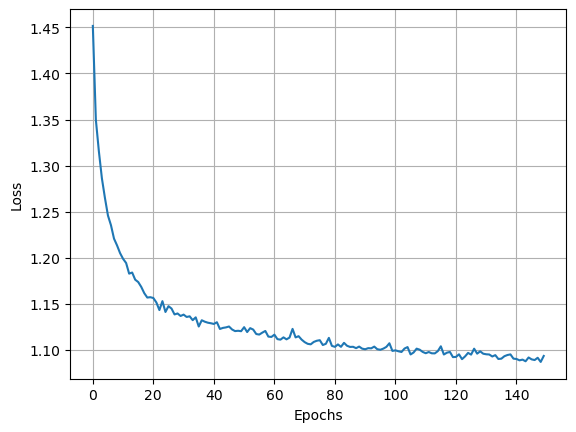

In [135]:
plt.plot(history_mapper.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

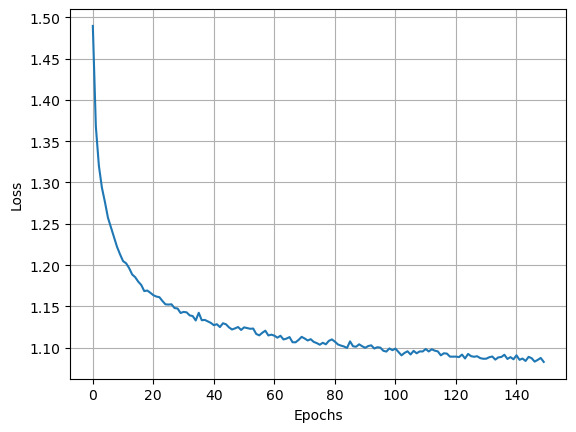

In [92]:
plt.plot(history_mapper.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [128]:
# mapper.save("models/mapper.keras")

In [136]:
# mapper = tf.keras.models.load_model("models/mapper.keras")

In [137]:
γ_n_pred = vae.decoder.predict(mapper.predict(φ_n))
γ_n_pred = np.round(γ_n_pred, 2)
# γ_hat_n_train += abs(np.min(γ_hat_n_train))
γ_n_pred = np.clip(γ_n_pred, a_min=0, a_max=1)

233/233 [==============================] - 1s 2ms/step


In [138]:
print(γ_n_pred.shape, np.min(γ_n_pred), np.max(γ_n_pred))

(7450, 32, 32, 32, 1) 0.0 1.0


133 
 predicted:


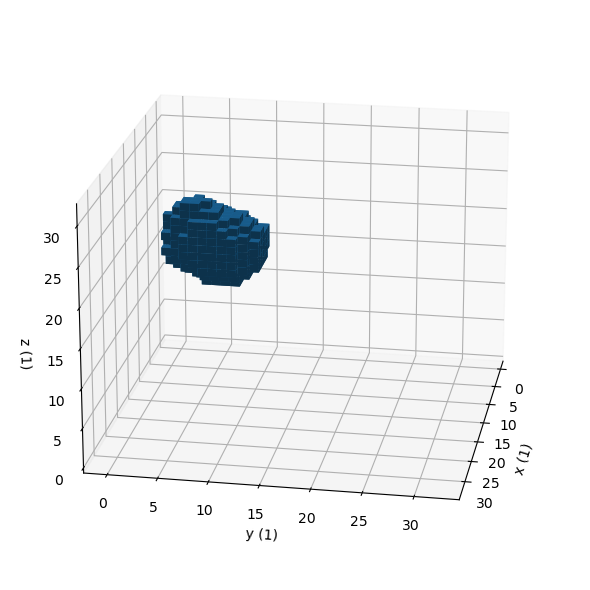

ground truth


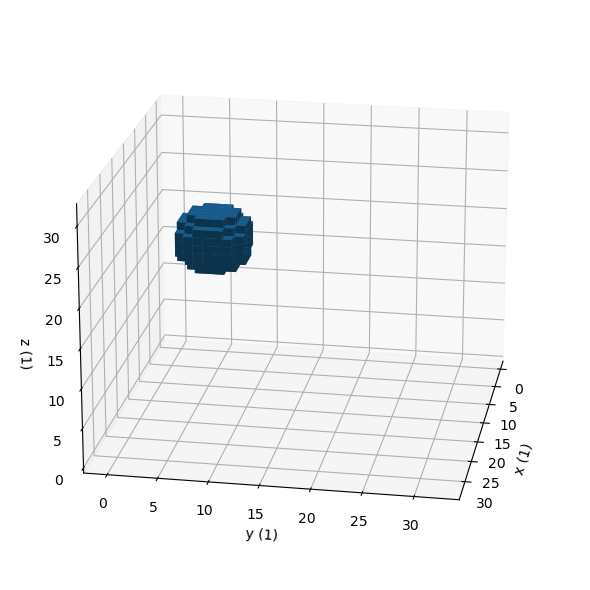

531 
 predicted:


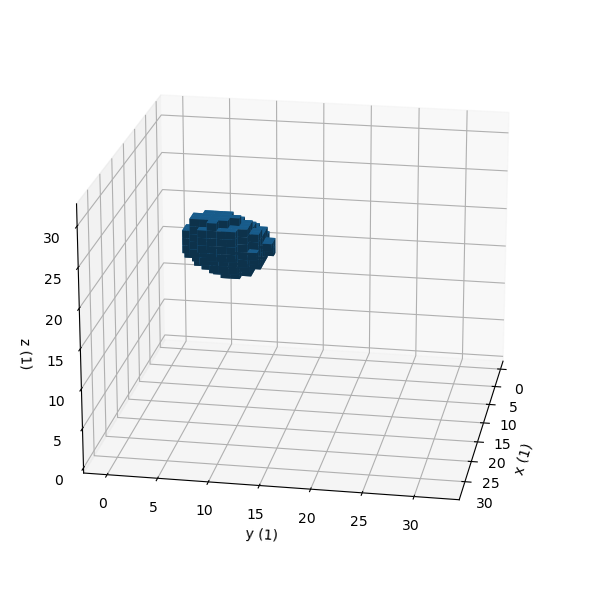

ground truth


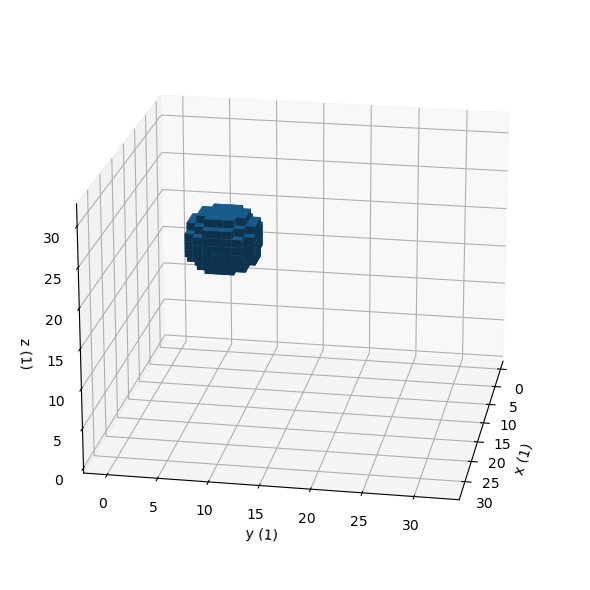

267 
 predicted:


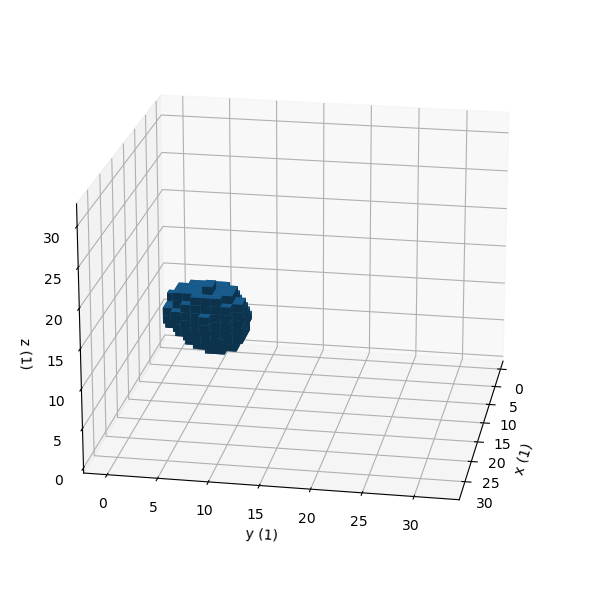

ground truth


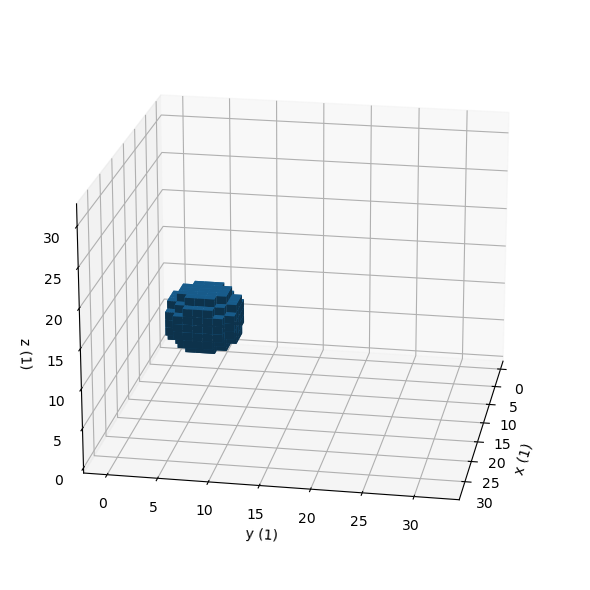

816 
 predicted:


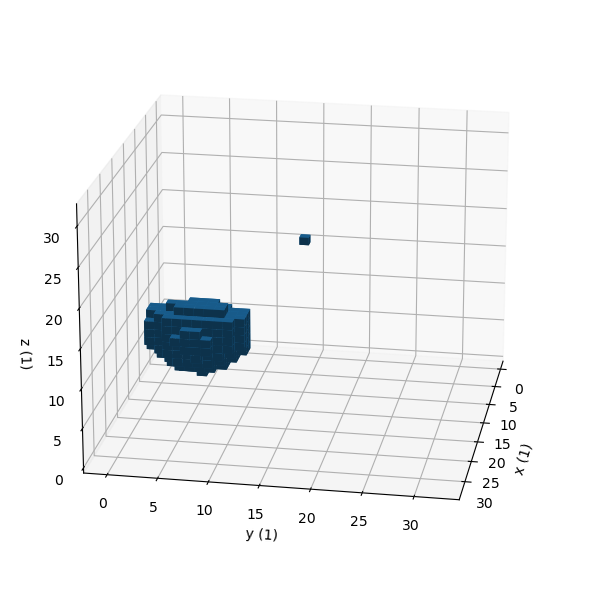

ground truth


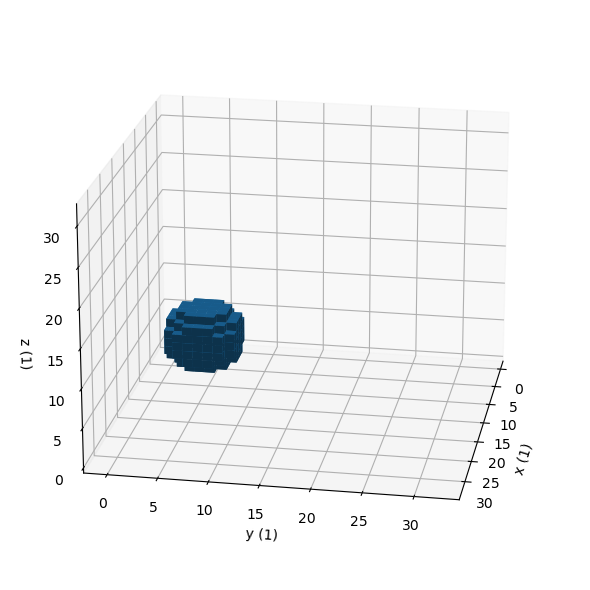

380 
 predicted:


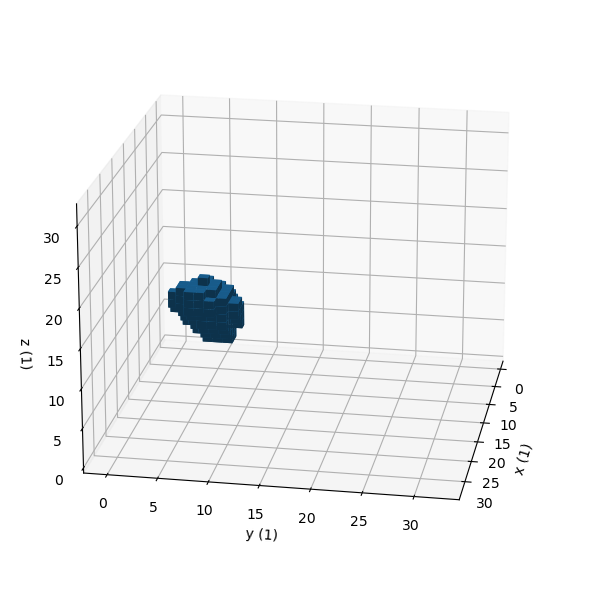

ground truth


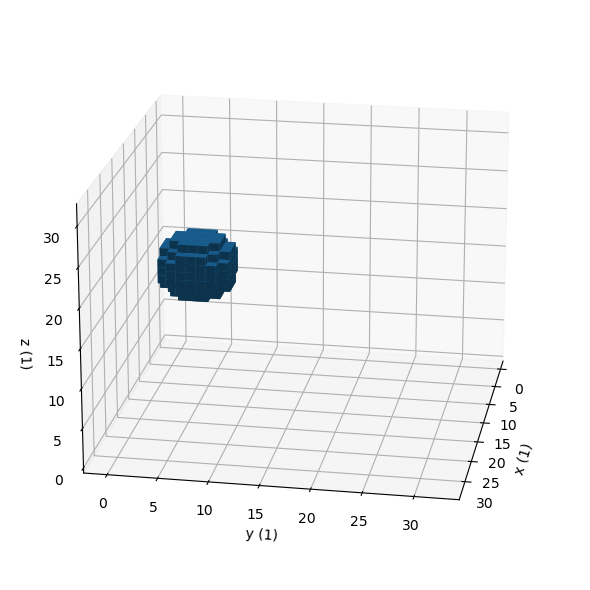

In [139]:
for idx in np.random.randint(0, 1000, 5):
    print(idx, "\n predicted:")
    plot_voxel(γ_n_pred[idx, :, :, :, 0])
    print("ground truth")
    plot_voxel(γ_n[idx])

In [140]:
def compute_voxel_err(predicted_voxels, true_voxels):
    com_pred = center_of_mass(predicted_voxels)
    com_true = center_of_mass(true_voxels)

    return np.array(com_true) - np.array(com_pred)


def visualize_errors(errors, in_percent=True, voxel_val_max=32, save=False):
    if in_percent:
        errors = errors / voxel_val_max * 100
    data = {"x-pos": errors[:, 0], "y-pos": errors[:, 1], "z-pos": errors[:, 2]}
    df = pd.DataFrame(data)
    plt.figure(figsize=(6, 3))
    sns.boxplot(data=df, showfliers=False)
    # plt.ylim([-1,3])
    if in_percent:
        plt.ylabel("Error (%)")
    else:
        plt.ylabel("Error (Voxel)")
    plt.grid()
    plt.tight_layout()
    if save:
        plt.savefig("images/reconstruction_axis_error.pdf")
    plt.show()


def center_of_mass(voxel_matrix):
    x_coords, y_coords, z_coords = np.meshgrid(
        np.arange(voxel_matrix.shape[0]),
        np.arange(voxel_matrix.shape[1]),
        np.arange(voxel_matrix.shape[2]),
    )
    total_mass = np.sum(voxel_matrix)
    center_x = np.sum(x_coords * voxel_matrix) / total_mass
    center_y = np.sum(y_coords * voxel_matrix) / total_mass
    center_z = np.sum(z_coords * voxel_matrix) / total_mass

    return center_y, center_x, center_z

In [141]:
errors = list()
for i in range(1000):
    errors.append(compute_voxel_err(γ_n_pred[i, :, :, :, 0], γ_n[i]))
errors = np.array(errors)

/tmp/ipykernel_65852/2460030471.py:34: RuntimeWarning: invalid value encountered in double_scalars
  center_x = np.sum(x_coords * voxel_matrix) / total_mass
/tmp/ipykernel_65852/2460030471.py:35: RuntimeWarning: invalid value encountered in double_scalars
  center_y = np.sum(y_coords * voxel_matrix) / total_mass
/tmp/ipykernel_65852/2460030471.py:36: RuntimeWarning: invalid value encountered in double_scalars
  center_z = np.sum(z_coords * voxel_matrix) / total_mass


In [144]:
np.sum(γ_n[i])

251

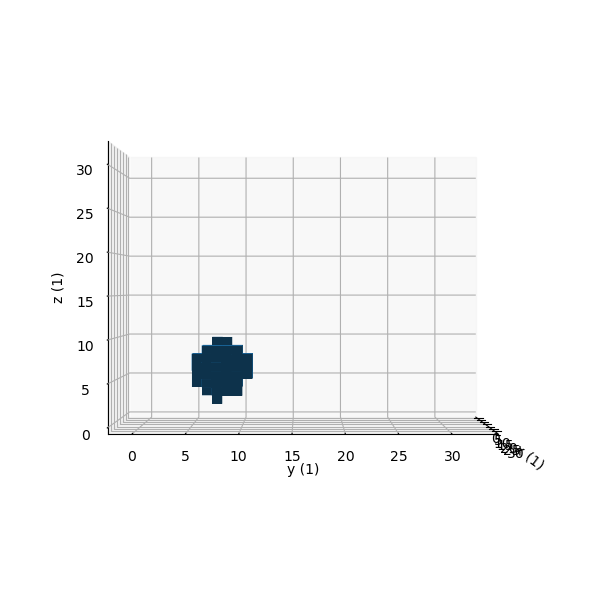

(16.798869836586533, 7.525327667906345, 5.9883737474192404)


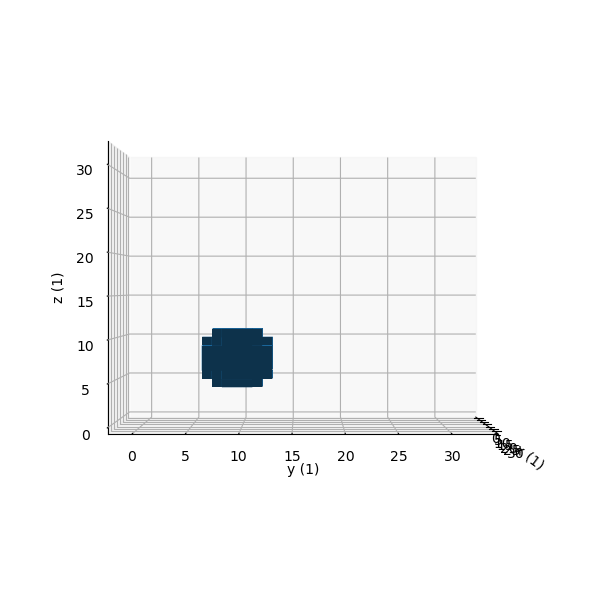

(16.0, 9.0, 7.0)
voxel error: [-0.79886984  1.47467233  1.01162625]


In [147]:
i = 1105

azim = 0
elev = 0

plot_voxel(γ_n_pred[i, :, :, :, 0], azim=azim, elev=elev)
print(center_of_mass(γ_n_pred[i, :, :, :, 0]))

plot_voxel(γ_n[i], azim=azim, elev=elev)
print(center_of_mass(γ_n[i]))

print("voxel error:", compute_voxel_err(γ_n_pred[i, :, :, :, 0], γ_n[i]))

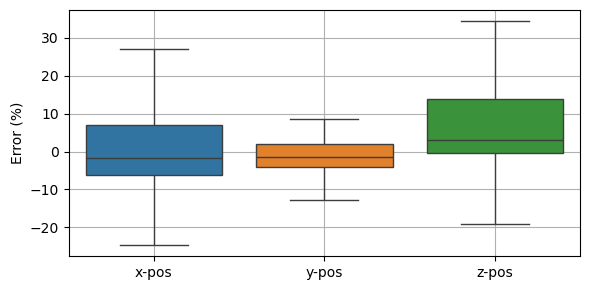

In [148]:
visualize_errors(errors, save=False)